In [13]:
import xarray as xr
import numpy as np
import pandas as pd

In [14]:
land_sea_mask = xr.open_dataset('/Users/fabienaugsburger/Documents/GitHub/master-project-cleaned/data/land_sea_mask_test/ERA5_2021-1_land_sea_mask.nc')
land_sea_mask_eu = xr.open_dataset('/Users/fabienaugsburger/Documents/GitHub/master-project-cleaned/pre_processing/maps/europe_border_test.tif', engine='rasterio')


In [15]:
gusts = xr.open_dataset('/Users/fabienaugsburger/Documents/GitHub/master-project-cleaned/data/gust_test/data_stream_oper.nc')
storm_dates = pd.read_csv('/Users/fabienaugsburger/Documents/GitHub/master-project-cleaned/pre_processing/tracks/storms_dates_steps_index_landfall.csv',
                          delimiter=';')

In [16]:
gusts

<xarray.Dataset>
Dimensions:     (valid_time: 8760, latitude: 721, longitude: 1440)
Coordinates:
    number      int64 ...
  * valid_time  (valid_time) datetime64[ns] 1990-01-01 ... 1990-12-31T23:00:00
  * latitude    (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    expver      (valid_time) object ...
Data variables:
    i10fg       (valid_time, latitude, longitude) float32 ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-09-27T15:35 GRIB to CDM+CF via cfgrib-0.9.1...

In [17]:
land_sea_mask_eu

<xarray.Dataset>
Dimensions:      (band: 1, x: 402, y: 218)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -31.38 -31.12 -30.88 -30.62 ... 68.38 68.62 68.88
  * y            (y) float64 81.88 81.62 81.38 81.12 ... 28.38 28.12 27.88 27.62
    spatial_ref  int64 ...
Data variables:
    band_data    (band, y, x) float32 ...

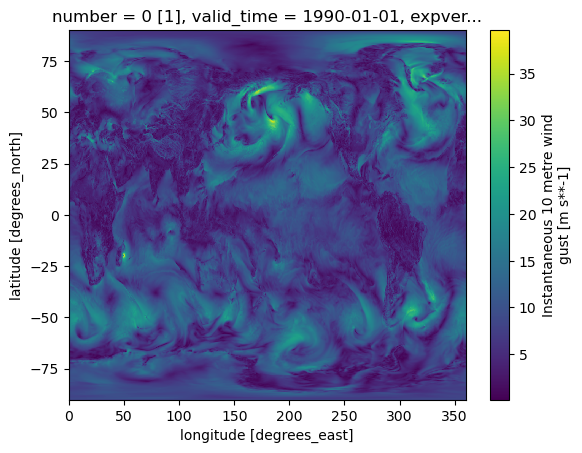

In [18]:
gusts['i10fg'][0].plot()

In [19]:
time_landfall = storm_dates['eu_landfall_date'][0]
time_end = storm_dates['end_date'][0]

In [20]:
# slice the gust data to the time of landfall to end of storm

gusts_landfall = gusts.sel(valid_time=slice(time_landfall, time_end))

gusts_landfall

<xarray.Dataset>
Dimensions:     (valid_time: 122, latitude: 721, longitude: 1440)
Coordinates:
    number      int64 ...
  * valid_time  (valid_time) datetime64[ns] 1990-01-23T17:00:00 ... 1990-01-2...
  * latitude    (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    expver      (valid_time) object ...
Data variables:
    i10fg       (valid_time, latitude, longitude) float32 ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-09-27T15:35 GRIB to CDM+CF via cfgrib-0.9.1...

In [21]:
# extract the min and max of lat and lon of the land sea mask eu 
y_eu_max = int((np.round(land_sea_mask_eu['y']*4,0)/4).max())
x_eu_min = int((np.round(land_sea_mask_eu['x']*4,0)/4).min())+360
x_eu_max = int((np.round(land_sea_mask_eu['x']*4,0)/4).max())
y_eu_min = int((np.round(land_sea_mask_eu['y']*4,0)/4).min())

# roll the gusts data 

gusts_landfall_rolled = gusts_landfall.roll(longitude=180, roll_coords='longitude')

gusts_landfall_eu = gusts_landfall_rolled.sel(latitude=slice(y_eu_max, y_eu_min), longitude=slice(x_eu_min, x_eu_max))

#gusts_landfall_eu = gusts_landfall.interp_like(land_sea_mask_eu)

gusts_landfall_eu

<xarray.Dataset>
Dimensions:     (valid_time: 122, latitude: 221, longitude: 401)
Coordinates:
    number      int64 ...
  * valid_time  (valid_time) datetime64[ns] 1990-01-23T17:00:00 ... 1990-01-2...
  * latitude    (latitude) float64 82.0 81.75 81.5 81.25 ... 27.5 27.25 27.0
  * longitude   (longitude) float64 329.0 329.2 329.5 329.8 ... 68.5 68.75 69.0
    expver      (valid_time) object ...
Data variables:
    i10fg       (valid_time, latitude, longitude) float32 4.241 4.26 ... 4.886
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-09-27T15:35 GRIB to CDM+CF via cfgrib-0.9.1...

In [22]:
#first_storm_max = gusts_landfall_eu.max(dim='valid_time')

global_first_storm_max = gusts_landfall.max(dim='valid_time')

In [23]:
# save global_storm_max to netcdf

#global_first_storm_max.to_netcdf('/Users/fabienaugsburger/Documents/GitHub/master-project-cleaned/pre_processing/maps/global_first_storm_max.nc')

# to raster


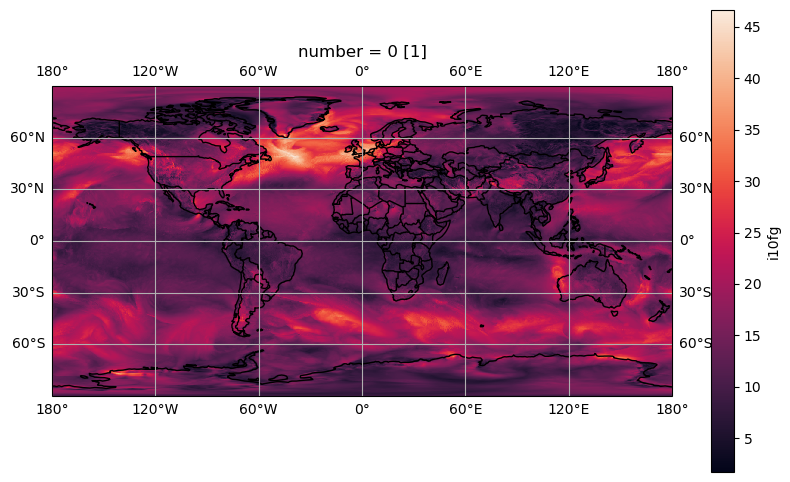

In [25]:
#first_storm_max.sortby('longitude', ascending=True)

# only work with non rolled dataset

# using seaborn to plot the data with borders shown on the map

import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

# Create a plot with Cartopy
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the xarray data (assuming lat/lon coordinates are available in the dataset)
global_first_storm_max['i10fg'].plot(ax=ax, transform=ccrs.PlateCarree(), cmap='rocket')

# Add country borders and other features
ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1, edgecolor='black')
ax.add_feature(cfeature.COASTLINE, linestyle='-', linewidth=1)

# Optionally, you can add gridlines
ax.gridlines(draw_labels=True)

# Show the plot
plt.show()

In [30]:
import xarray as xr
import rasterio
from rasterio.transform import from_origin
from rasterio.crs import CRS

# Assuming first_storm_max is your xarray DataArray with latitude and longitude
# Example: first_storm_max['i10fg'] is the variable to plot

# Step 1: Extract data and coordinates from the DataArray
data = global_first_storm_max['i10fg'].values  # Extract the data values
lat = global_first_storm_max['latitude'].values  # Extract latitude values
lon = global_first_storm_max['longitude'].values  # Extract longitude values

# Step 2a : Wrap longitudes from 0-360 to -180-180
lon = np.where(lon > 180, lon - 360, lon)  # Adjust longitudes to be in the range -180 to 180

# Step 2b: Sort the longitude values and the corresponding data
# This is necessary because the dataset might no longer be ordered properly after adjusting longitudes
sorted_idx = np.argsort(lon)
lon = lon[sorted_idx]
data = data[:, sorted_idx]  # Sort the data accordingly


# Step 2c: Define the affine transform (with a negative y pixel size to correct for the flipped map)
transform = from_origin(lon.min(), lat.max(), lon[1] - lon[0], -(lat[1] - lat[0]))  # Note the negative value for the y-direction

# Step 3: Define the CRS (Coordinate Reference System) for WGS84
crs_wgs84 = CRS.from_epsg(4326)  # EPSG code for WGS84

# Step 4: Set metadata and save the raster file
with rasterio.open(
    'output_raster_wgs84.tif',  # Output filename
    'w',  # Write mode
    driver='GTiff',  # GeoTIFF format
    height=data.shape[0],  # Number of rows (height)
    width=data.shape[1],  # Number of columns (width)
    count=1,  # Number of bands
    dtype=data.dtype,  # Data type of the array (e.g., float32)
    crs=crs_wgs84,  # Coordinate Reference System (WGS84)
    transform=transform,  # Affine transformation matrix
    nodata=-9999  # Define NoData value
) as dst:
    # Step 5: Write the data to the raster file
    dst.write(data, 1)  # Write the first band

print("Raster saved with WGS84 projection.")

Raster saved with WGS84 projection.


In [31]:
with rasterio.open('output_raster_wgs84.tif') as src:
    print("CRS:", src.crs)  # Should print the CRS
    print("Transform:", src.transform)  # Should print the affine transformation

CRS: EPSG:4326
Transform: | 0.25, 0.00,-179.75|
| 0.00,-0.25, 90.00|
| 0.00, 0.00, 1.00|


In [1]:
import xarray as xr
def open_monthly_nc(year, variable, months, way, level=0):
    try :
        datasets = [xr.open_dataset(f'{way}{variable}/ERA5_{year}-{month}_{variable}.nc') for month in months]
    except:
        print('Format of the raw variables must be {variable}/ERA5_{year}-{month}_{variable}.nc')
        if variable == 'geopotential' and level != 0:
            datasets = [dataset.sel(level=level) for dataset in datasets]
    return xr.concat(datasets, dim='time')

test = open_monthly_nc(1990, 'instantaneous_10m_wind_gust', ['01', '02', '03'], '/Users/fabienaugsburger/Documents/GitHub/master-project-cleaned/data/instantaneous_10m_wind_gust/')

Format of the raw variables must be {variable}/ERA5_{year}-{month}_{variable}.nc


UnboundLocalError: cannot access local variable 'datasets' where it is not associated with a value

In [2]:
gust_test = xr.open_dataset('/Users/fabienaugsburger/Documents/GitHub/master-project-cleaned/data/raw_data/gust_test/data_stream_oper.nc')
year = 1991
for i in range (1,4):
    if i == 1:
        day = 31
    elif i == 2:
        day = 28
    else:
        day = 31
    locals()['month_{i}'] = gust_test.sel(valid_time=slice(f'{year}-{i}-{int(1)}', f'{year}-{i}-{day}'))


In [4]:
# import the max storm.tif and convert it to netcdf

import rasterio 
from rasterio.plot import show
import xarray as xr
import numpy as np

max_storm = rasterio.open('/Users/fabienaugsburger/Documents/GitHub/master-project-cleaned/pre_processing/maps/wind_maps/max_all_storms.tif')

# convert the max storm to netcdf

max_storm_data = max_storm.read(1)
max_storm_data = np.where(max_storm_data == 0, np.nan, max_storm_data)

max_storm_data = xr.DataArray(max_storm_data, dims=['y', 'x'], coords={'y': np.arange(max_storm_data.shape[0]), 'x': np.arange(max_storm_data.shape[1])})
max_storm_data




<xarray.DataArray (y: 153, x: 209)>
array([[1.79000000e+308, 1.79000000e+308, 1.79000000e+308, ...,
        1.79000000e+308, 1.79000000e+308, 1.79000000e+308],
       [1.79000000e+308, 1.79000000e+308, 1.79000000e+308, ...,
        1.79000000e+308, 1.79000000e+308, 1.79000000e+308],
       [1.79000000e+308, 1.79000000e+308, 1.79000000e+308, ...,
        1.79000000e+308, 1.79000000e+308, 1.79000000e+308],
       ...,
       [1.79000000e+308, 1.79000000e+308, 1.79000000e+308, ...,
        2.14895618e+001, 2.10330238e+001, 2.10511282e+001],
       [1.79000000e+308, 1.79000000e+308, 1.79000000e+308, ...,
        2.12216138e+001, 2.11547144e+001, 2.11640659e+001],
       [1.79000000e+308, 1.79000000e+308, 1.79000000e+308, ...,
        2.08964683e+001, 2.08778160e+001, 2.05893066e+001]])
Coordinates:
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 144 145 146 147 148 149 150 151 152
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 200 201 202 203 204 205 206 207 208

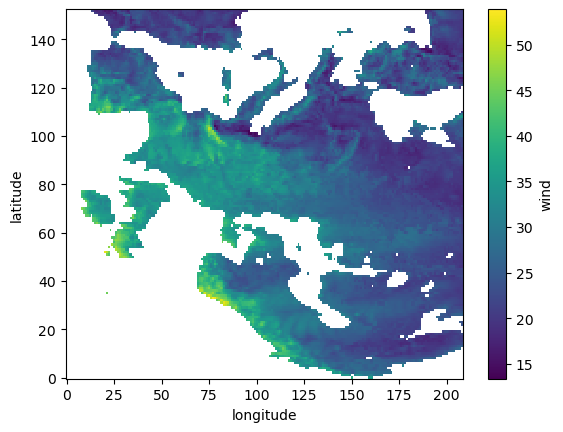

In [8]:
test_max = xr.open_dataset('/Users/fabienaugsburger/Documents/GitHub/master-project-cleaned/pre_processing/maps/wind_maps/max_all_storms.nc')

test_max['wind'].plot()

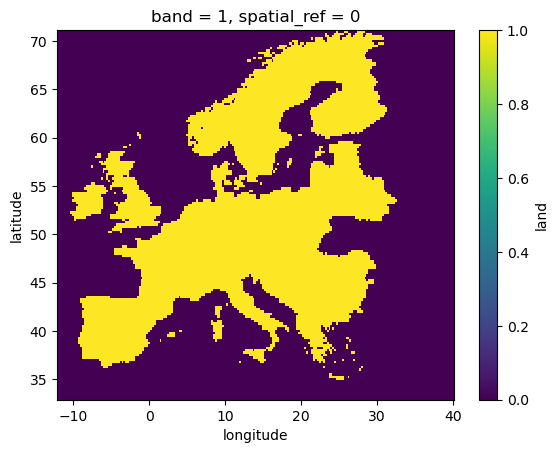

In [1]:
import xarray as xr
import numpy as np

# Open the raster file

raster = xr.open_dataset('/Users/fabienaugsburger/Documents/GitHub/master-project-cleaned/pre_processing/maps/QGIS/raster/eu_final_raster.tif', engine='rasterio')
#raster['band_data'].plot()

# change the names of the coordinates
raster = raster.rename({'band_data': 'land', 'x': 'longitude', 'y': 'latitude'})

# change nan values to 0
raster = raster.where(~np.isnan(raster), 0)

#raster['latitude'] = np.linspace(90, -90, raster.sizes['y'])
#raster['longitude'] = np.linspace(-180, 180, raster.sizes['x'])

'''raster['y'] = raster['y'].rename('latitude')
raster['longitude'] = raster['longitude'].rename('x')'''

raster.to_netcdf('eu_final_raster.nc')

'''raster_nc = xr.open_dataset('eu_final_raster.nc')
raster_nc['band_data'].plot()'''

#wind =
# xr.open_dataset('/Users/fabienaugsburger/Documents/GitHub/master-project-cleaned/pre_processing/maps/wind_maps/2_DARIA.tif', engine='rasterio')
#wind
raster['land'].plot()

In [ ]:
#year = int(storm_dates['start_date'][index][:4])
index = 2

dataset, specific_var = process_data(variable, year, input_path, level=0)

eu = xr.open_dataset('/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ECMWF/ERA5/SL/land_sea_mask/ERA5_2021-1_land_sea_mask.nc')
# remove the time dimension
land_sea_mask = land_sea_mask.sel(time='2021-01-01T00:00:00')

time_landfall = storm_dates['eu_landfall_date'][index]
time_end = storm_dates['end_date'][index]

#time_landfall = '1990-01-23T17:00:00.000000000'
#time_end = '1990-01-28T18:00:00.000000000'

# slice the gust data to the time of landfall to end of storm

global_storm = dataset.sel(time=slice(time_landfall, time_end))
global_first_storm_max = global_storm.max(dim='time')

#global_first_storm_max_eu = global_first_storm_max.roll(longitude=180, roll_coords='longitude').sel(latitude=slice(71, 33), longitude=slice(338, 40))
#global_first_storm_max_eu = global_first_storm_max_eu.roll(longitude=90, roll_coords='longitude')

land_wind = global_first_storm_max.where(land_sea_mask['lsm'] >= 0.5)
land_wind = land_wind.assign_coords(time=time_landfall)

storm_name_value = storm_dates['storm_name'][index]
storm_index_value = storm_dates['storm_index'][index]
storm_name = f'{storm_name_value}_{storm_index_value}'

#sorted_data = land_wind[specific_var].sortby(['longitude', 'latitude'])

land_wind['longitude'] = xr.where(land_wind['longitude'] > 180, land_wind['longitude'] - 360, land_wind['longitude'])

# Step 2: Sort the dataset by longitude to ensure it's in the right order
sorted_data = land_wind.sortby('longitude')

sorted_data_eu = sorted_data.sel(latitude=slice(71, 33), longitude=slice(-12, 40))
sorted_data_eu = sorted_data_eu.assign_coords(time=time_landfall)

# setting the projection
sorted_data_eu = sorted_data_eu.rio.write_crs("EPSG:4326")# sorted_data.rio.write_crs("EPSG:4326")

sorted_data_reprojected = sorted_data_eu.rio.reproject(
    sorted_data_eu.rio.crs,
    resolution=0.25  # Setting the desired pixel size
)

sorted_data_reprojected.rio.to_raster(f'{output_path}/{storm_name}.tif')

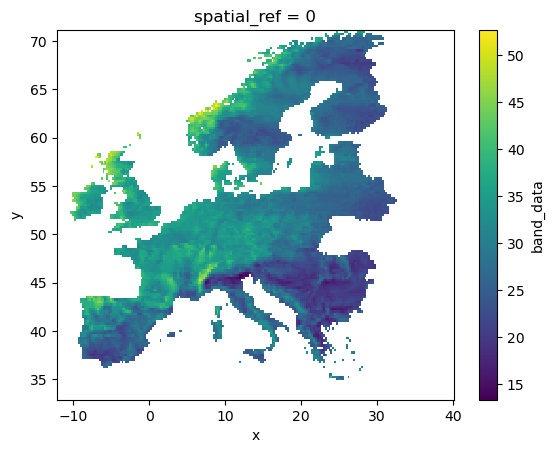

In [39]:
# open a raster file with xarray

import matplotlib.pyplot as plt
raster = xr.open_dataset('/Users/fabienaugsburger/Documents/GitHub/master-project-cleaned/pre_processing/maps/wind_maps/rasters/50_C3S_STORM_TRACKS_ERA5.tif', engine='rasterio')
#raster['band_data'].plot()

rasters = xr.open_mfdataset('/Users/fabienaugsburger/Documents/GitHub/master-project-cleaned/pre_processing/maps/wind_maps/rasters/*.tif', 
                            engine='rasterio', 
                            combine='nested', 
                            concat_dim='band')
'''
for i in range(0,94):
    rasters['band_data'][i].plot()
    print(i)
    plt.show()'''

max_all_storms = rasters['band_data'].max(dim='band')
max_all_storms.plot()
max_all_storms

i10fg = max_all_storms
 
i10fg = i10fg.rio.set_spatial_dims(x_dim='x', y_dim='y')
i10fg.rio.crs
 
i10fg.rio.write_crs("epsg:4326", inplace=True)
 
i10fg.rio.to_raster(r"max_all_storms.tif")

In [37]:
max_all_storms

<xarray.DataArray 'band_data' (y: 153, x: 209)>
dask.array<_nanmax_skip-aggregate, shape=(153, 209), dtype=float64, chunksize=(4, 209), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 -12.0 -11.75 -11.5 -11.25 ... 39.25 39.5 39.75 40.0
  * y            (y) float64 71.0 70.75 70.5 70.25 ... 33.75 33.5 33.25 33.0
    spatial_ref  int64 0